In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import xgboost as xgb
import shap
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [ ]:
loan_data = pd.read_csv('data/loan_data.csv')
print(loan_data.head().to_markdown())

|    |   person_age | person_gender   | person_education   |   person_income |   person_emp_exp | person_home_ownership   |   loan_amnt | loan_intent   |   loan_int_rate |   loan_percent_income |   cb_person_cred_hist_length |   credit_score | previous_loan_defaults_on_file   |   loan_status |
|---:|-------------:|:----------------|:-------------------|----------------:|-----------------:|:------------------------|------------:|:--------------|----------------:|----------------------:|-----------------------------:|---------------:|:---------------------------------|--------------:|
|  0 |           22 | female          | Master             |           71948 |                0 | RENT                    |       35000 | PERSONAL      |           16.02 |                  0.49 |                            3 |            561 | No                               |             1 |
|  1 |           21 | female          | High School        |           12282 |                0 | OWN              

In [ ]:
# Initial Exploration/ Info
def initial_data_check(df):
    print("Dataset Info:")
    print(df.info())

    print("\nMissing Values:")
    print(df.isnull().sum())

    print("\nSummary Statistics:")
    print(df.describe())

    print("\nCategorical Features Summary:")
    for col in df.select_dtypes(include=['object']).columns:
        print(f"{col}: {df[col].unique()}")

In [ ]:
initial_data_check(loan_data)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defa

> - No Missing Values: All 45,000 records have complete data across 14 columns.
> - Proper Data Types: Numerical and categorical columns are correctly classified.

### Bi Variate Analysis

In [ ]:
# Bivariate Analysis
# Loan Approval Rates by Categorical Features
def plot_loan_approval_rates(df, categorical_cols):
    plt.figure(figsize=(14, 8))
    for i, col in enumerate(categorical_cols, 1):
        plt.subplot(2, 2, i)
        approval_rates = df.groupby(col)['loan_status'].mean() * 100
        sns.barplot(x=approval_rates.index, y=approval_rates.values, hue=approval_rates.index, palette='coolwarm', legend=False)
        plt.title(f'Loan Approval Rate by {col}')
        plt.ylabel('Approval Rate (%)')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

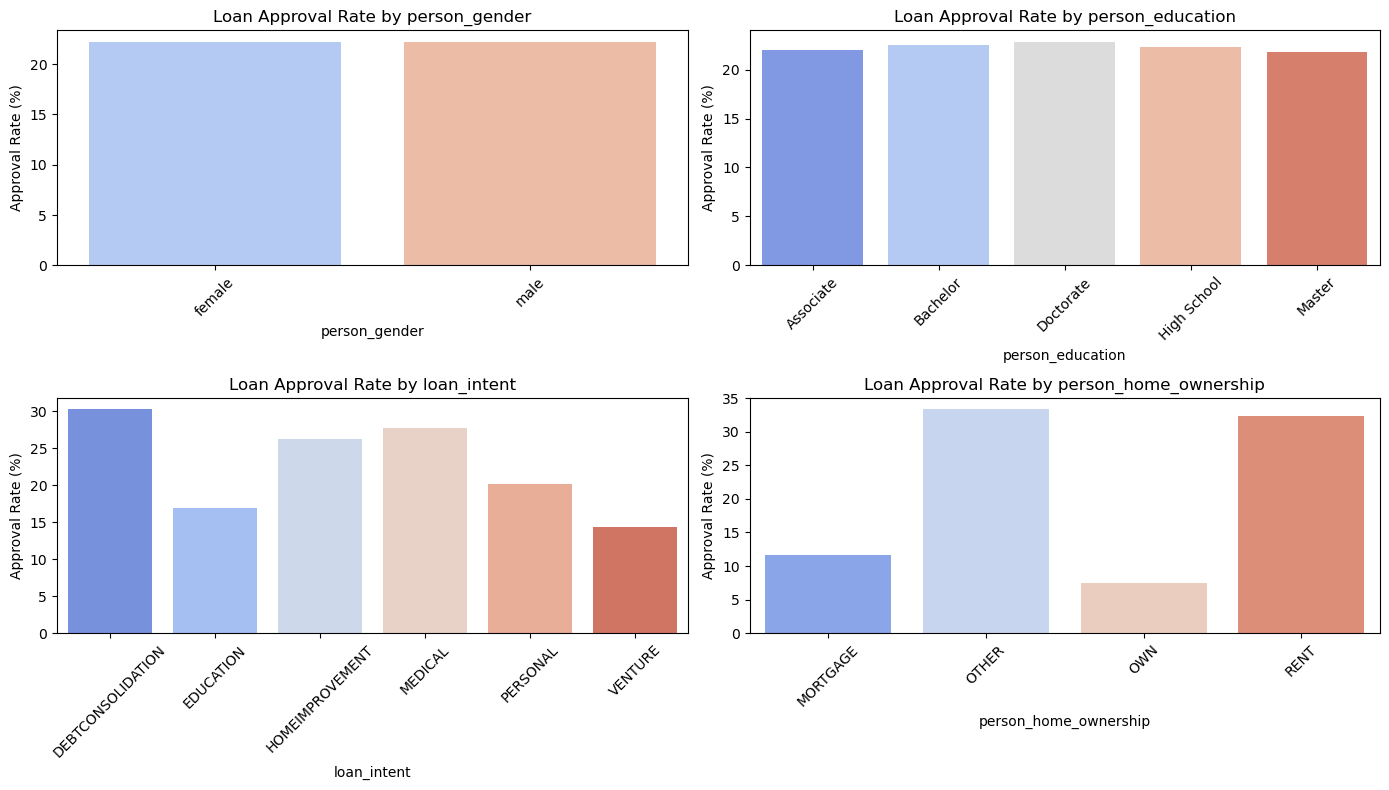

In [ ]:
categorical_features = ['person_gender', 'person_education', 'loan_intent', 'person_home_ownership']
plot_loan_approval_rates(loan_data, categorical_features)

> - Gender & Education: No major impact on loan approval rates.
> - Loan Intent: Debt Consolidation loans have the highest approval, Education & Venture loans the lowest.
> - Home Ownership: Renters get approved more than homeowners & mortgage holders, possibly due to existing debts.

In [ ]:
# Bivariate Analysis
# Stacked Bar Chart for Previous Loan Defaults
def plot_previous_loan_defaults(df):
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x='previous_loan_defaults_on_file', hue='loan_status', palette='coolwarm')
    plt.title('Loan Approval Based on Previous Loan Defaults')
    plt.xlabel('Previous Loan Defaults')
    plt.ylabel('Count')
    plt.legend(['Rejected', 'Approved'], loc='upper right')
    plt.xticks(rotation=0)
    plt.show()

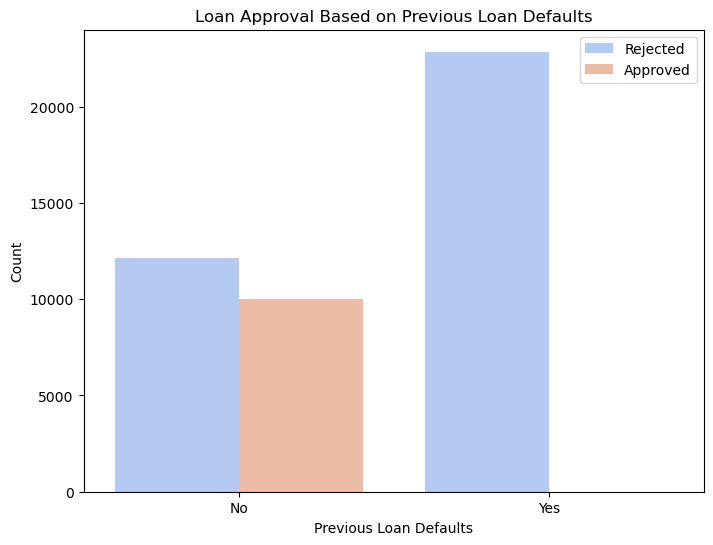

In [ ]:
plot_previous_loan_defaults(loan_data)

> - Applicants with previous loan defaults have a significantly lower approval rate.
> - Most defaulters get rejected, indicating that past credit behavior strongly influences approval.
> - Non-defaulters have a much higher chance of loan approval.

In [ ]:
# Bivariate Analysis
# Box Plots for Income, Credit Score, and Loan Amount

def plot_box_plots(df, numerical_cols):
    plt.figure(figsize=(18, 6))
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(1, 3, i)
        sns.boxplot(x='loan_status', y=df[col], data=df, hue='loan_status', palette='coolwarm', legend=False)
        plt.title(f'Loan Approval by {col}')
        plt.xlabel('Loan Status (0 = Rejected, 1 = Approved)')
        plt.ylabel(col)
    plt.tight_layout()
    plt.show()

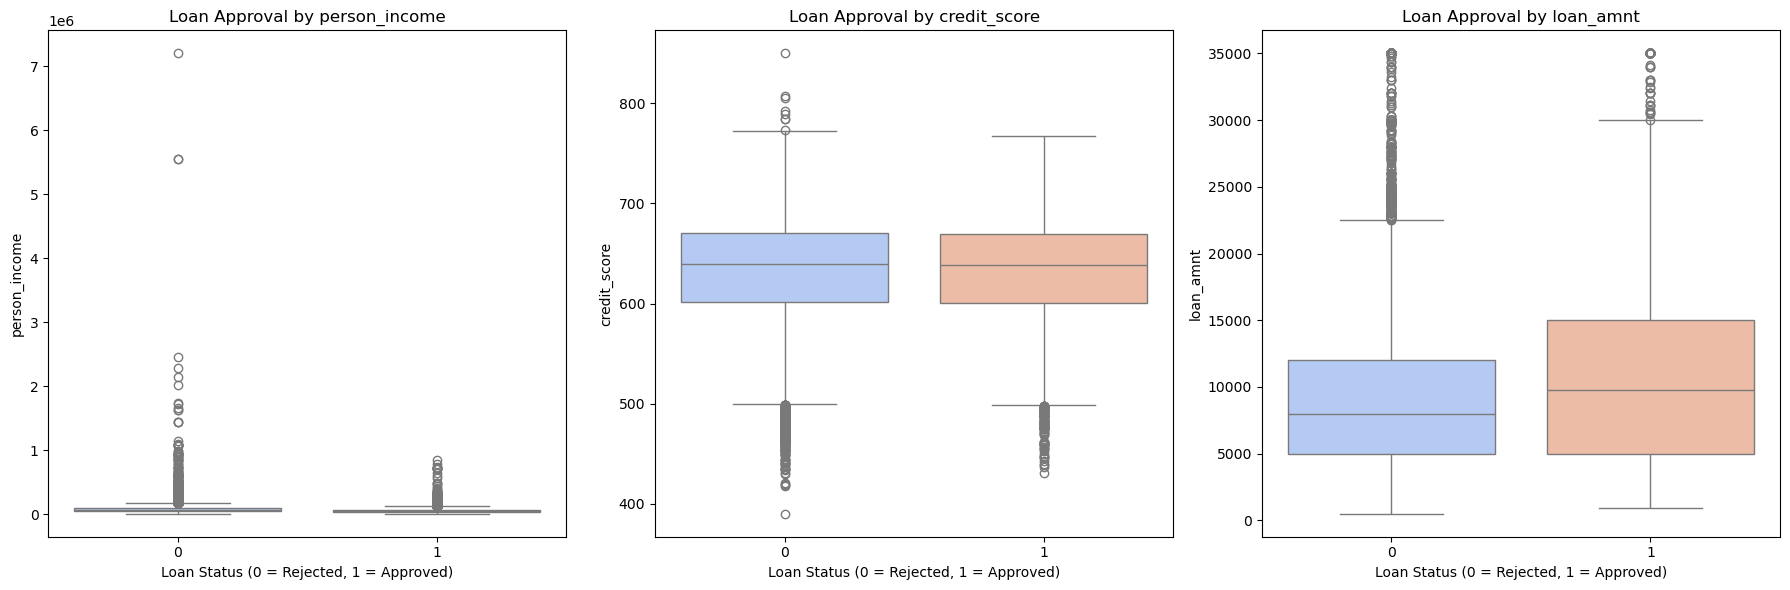

In [ ]:
numerical_features = ['person_income', 'credit_score', 'loan_amnt']
plot_box_plots(loan_data, numerical_features)

> - __Income & Loan Approval:__ Approved and rejected applicants have similar income ranges, but extreme high-income outliers exist.
> - __Credit Score Impact:__ Higher credit scores correlate with approvals, while many rejected applicants have scores below 600.
> - __Loan Amount & Approval:__ Approved loans tend to have higher amounts than rejected ones, indicating that larger loans are still considered for approval.

In [ ]:
# Bivariate Analysis
# Violin Plot for Loan Percent Income
def plot_violin_loan_percent_income(df):
    plt.figure(figsize=(8, 6))
    sns.violinplot(x='loan_status', y='loan_percent_income', data=df, hue='loan_status', palette='coolwarm', legend=False)
    plt.title('Loan Approval by Loan Percent Income')
    plt.xlabel('Loan Status (0 = Rejected, 1 = Approved)')
    plt.ylabel('Loan Percent Income')
    plt.show()

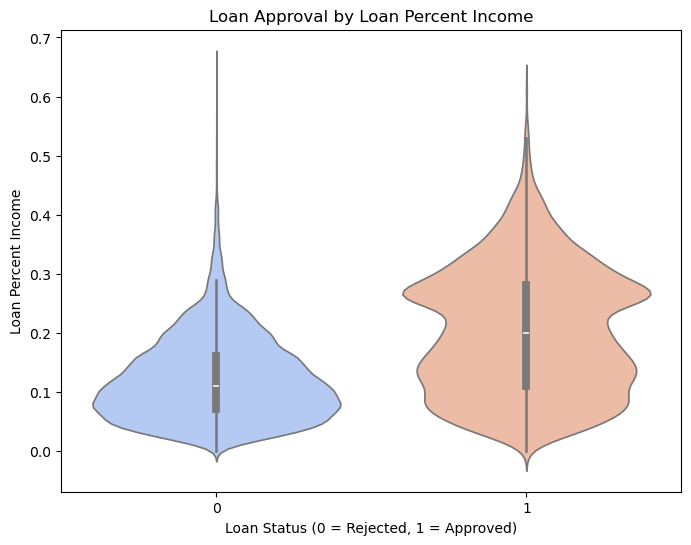

In [ ]:
plot_violin_loan_percent_income(loan_data)

> - Higher Debt-to-Income Ratio → More Rejections
> - Approved Loans Mostly Fall in the 10-30% Range
> - Rejections Increase for Ratios Above 40%

In [ ]:
# Bivariate Analysis
# KDE Plot for Loan Interest Rate
def plot_kde_loan_interest_rate(df):
    plt.figure(figsize=(8, 6))
    sns.kdeplot(df[df['loan_status'] == 1]['loan_int_rate'], label='Approved', fill=True, color='blue')
    sns.kdeplot(df[df['loan_status'] == 0]['loan_int_rate'], label='Rejected', fill=True, color='red')
    plt.title('Loan Interest Rate Distribution by Loan Status')
    plt.xlabel('Loan Interest Rate (%)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

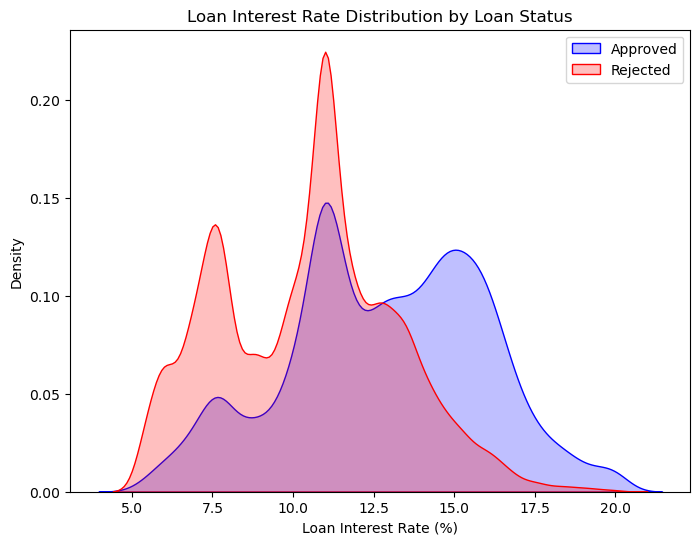

In [ ]:
plot_kde_loan_interest_rate(loan_data)

> - Higher interest rates → More rejections.
> - Approved loans cluster around 10-15%, while rejected loans peak around 10% but extend lower.
> - Lower interest rates (<8%) are mostly rejected, indicating higher-risk borrowers with lower rates might still get denied.